# pypsps: demo of learning UTE and ATE from simulated datasets

This notebook illustrates how to use `pypsps` for

* how to train PSPS deep nets from causal (simulated) datasets
 
* how to use model predictions/estimates to obtain UTE / ATE

In [1]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

In [2]:
import importlib
import os
import sys
import pathlib
import tensorflow as tf
import tensorflow.keras as tfk

from os.path import dirname
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import logging
import datetime
parent_path = dirname(pathlib.Path(pathlib.Path(os.getcwd())))

if parent_path not in sys.path:
    sys.path.insert(0, parent_path)

2024-04-22 23:22:49.845980: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-22 23:22:49.846011: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import pypsps
import pypsps.keras.layers
import pypsps.keras.losses
import pypsps.keras.metrics
import pypsps.keras.models
import pypsps.utils
import pypsps.inference
import pypsps.datasets

import pypress # for regularizers

In [4]:
import sklearn.metrics

def _eval_propensity(y_true, y_score):

    y_comb = pd.DataFrame({"treatment": y_true, "propensity_score": y_score})
    sns.displot(data=y_comb, x="propensity_score", hue="treatment")
    plt.show()
    # Data to plot precision - recall curve
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true, y_score)
    # Use AUC function to calculate the area under the curve of precision recall curve
    auc_precision_recall = sklearn.metrics.auc(recall, precision)
    print(auc_precision_recall, output_data[:, 1].mean())

    plt.plot(recall, precision)
    plt.grid()
    plt.show()

# Load datasets

In [5]:
feat_cols = []
treat_col = None
outcome_col = None

## Kang-Schafer

In [6]:
np.random.seed(123)
ks_sampler = pypsps.datasets.KangSchafer(true_ate=10) 
ks_data = ks_sampler.sample(n_samples=1000)
df = ks_data.to_data_frame()

treat_col = "treatment"
outcome_col = "outcome"
feat_cols = list(set(df.columns) - set([treat_col, outcome_col]))
feat_cols = [c for c in feat_cols if "x" in c]

df.head()

,outcome,treatment,z1,z2,z3,z4,x1,x2,x3,x4
0,185.861788,1,-1.085631,0.997345,0.282978,-1.506295,0.581110,10.745574,0.202998,379.901059
1,185.488662,1,-0.578600,1.651437,-2.426679,-0.428913,0.748787,11.058150,0.282511,450.395521
2,222.810098,0,1.265936,-0.866740,-0.678886,-0.094709,1.883192,9.809357,0.180959,362.466410
3,229.073054,0,1.491390,-0.638902,-0.443982,-0.434351,2.107906,9.882625,0.188639,358.221742
4,318.044041,0,2.205930,2.186786,1.004054,0.386186,3.013087,10.216971,0.326506,509.539087


# Lalonde

In [7]:
np.random.seed(123)
l_data = pypsps.datasets.lalonde.Lalonde(observational_control=True, add_is_unemployed_features=True)
df = l_data.to_data_frame()

treat_col = "treatment"
outcome_col = "earnings1978"
feat_cols = list(set(df.columns) - set([treat_col, outcome_col]))

df.head()

Reading data from http://www.nber.org/~rdehejia/data/nswre74_control.txt
Reading data from http://www.nber.org/~rdehejia/data/nswre74_treated.txt
Reading data from http://www.nber.org/~rdehejia/data/cps_controls.txt


,earnings1978,treatment,nodegree,education,earnings1974,age,married,hispanic,earnings1975,black,is_unemployed_1974,is_unemployed_1975
0,9930.0460,1.0,1.0,11.0,0.0,37.0,1.0,0.0,0.0,1.0,1.0,1.0
1,3595.8940,1.0,1.0,9.0,0.0,22.0,0.0,1.0,0.0,0.0,1.0,1.0
2,24909.4500,1.0,0.0,12.0,0.0,30.0,0.0,0.0,0.0,1.0,1.0,1.0
3,7506.1460,1.0,1.0,11.0,0.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0
4,289.7899,1.0,1.0,8.0,0.0,33.0,0.0,0.0,0.0,1.0,1.0,1.0


## Lunceford-Davidian

In [8]:
np.random.seed(123)
ld_sampler = pypsps.datasets.LuncefordDavidian(association="strong")
ld_data = ld_sampler.sample(n_samples=1000)
df = ld_data.to_data_frame()

treat_col = "treatment"
outcome_col = "outcome"
feat_cols = list(set(df.columns) - set([treat_col, outcome_col]))
feat_cols = [c for c in feat_cols if "x" in c]

df.head()

,outcome,treatment,x1,x2,x3,z1,z2,z3
0,4.645024,1,-0.344101,0.775747,0,-1.393593,-0.102446,0
1,-1.117382,1,0.750124,0.034337,0,0.929039,0.003968,0
2,3.501009,0,-1.185921,0.055304,0,-0.258622,1.609794,0
3,1.309775,1,-0.206458,-1.315277,0,1.613716,1.428301,0
4,3.778180,1,-1.812288,-0.664850,0,0.572627,1.366041,0


In [9]:
ld_data.naive_ate()

1.3429938920890778

# Summary stats of Causal dataset

In [10]:
print(df.groupby(treat_col).mean().T.round(2))

treatment     0     1
outcome    0.47  1.82
x1        -1.07 -0.81
x2        -0.84 -1.15
x3         0.19  0.29
z1         0.97  1.07
z2         0.99  1.06
z3         0.36  0.42


In [11]:
feat_cols

['x1', 'x3', 'x2']

# Feature, treatment, outcome: setup for model training and inference

In [12]:
X, treatment, y = df[feat_cols].astype(float), df[[treat_col]], df[[outcome_col]]
X.shape, treatment.shape, y.shape

((1000, 3), (1000, 1), (1000, 1))

In [13]:
# Naive difference in means
df.groupby(treat_col)[outcome_col].mean()

treatment
0    0.472039
1    1.815033
Name: outcome, dtype: float64

In [14]:
# Scale features using a standard scaler (for sake of illustration don't do train/test split; in practice use train/test split for scaling as well)
import sklearn

# scale only features that have > 2 values (non-binary)
val_counts = X.nunique()
binary_cols = val_counts[val_counts == 2].index.tolist()

X_nonbinary = X.drop(binary_cols, axis=1)
X_s = pd.concat([X[binary_cols], 
                 pd.DataFrame(sklearn.preprocessing.scale(X_nonbinary), index=X_nonbinary.index, columns=X_nonbinary.columns)], axis=1)
X_s

,x3,x1,x2
0,0.0,0.605236,1.766544
1,0.0,1.732671,1.030633
2,0.0,-0.262133,1.051445
3,0.0,0.747056,-0.308971
4,0.0,-0.907510,0.336632
...,...,...,...
995,0.0,-1.397577,0.318207
996,0.0,-1.568665,-1.135929
997,0.0,-1.629278,1.467248
998,0.0,-1.040693,-0.112352


# Model architecture

In [40]:
tf.random.set_seed(10)
model = pypsps.keras.models.build_toy_model(4, X_s.shape[1])
model.summary()
tf.keras.utils.plot_model(model)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 3)           12          ['input_5[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 features_and_treatment (Concat  (None, 4)           0           ['batch_normalization_6[0][

32/32 [==============================] - 0s 2ms/step


<Axes: >

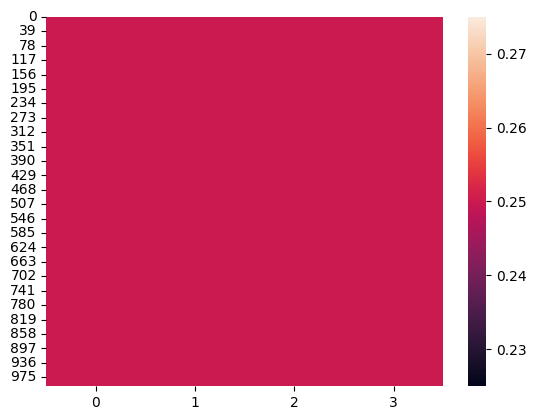

In [41]:
inputs = [X_s.values, treatment.values]
outputs = np.hstack([y.values, treatment.values])

preds = model.predict(inputs)

outcome_pred, const_scale, weights, propensity_score = pypsps.utils.split_y_pred(preds)
sns.heatmap(weights)

## Train model

In [42]:
# Preparet inputs and outputs (y_true) for losses / metrics and .fit() / .predict()
input_data = [X_s.values, treatment.values]
output_data = np.hstack([y.values, treatment.values])

# pre-training model predictions
y_pred = model.predict(input_data)
y_pred.shape

32/32 [==============================] - 0s 2ms/step


(1000, 13)

In [46]:
psps_outcome_loss = pypsps.keras.losses.OutcomeLoss(loss=pypsps.keras.losses.NegloglikNormal(reduction="none"), reduction="auto")
psps_treat_loss = pypsps.keras.losses.TreatmentLoss(loss=tf.keras.losses.BinaryCrossentropy(reduction="none"), reduction="auto")
psps_outcome_loss(output_data, y_pred), psps_treat_loss(output_data, y_pred)

(<tf.Tensor: shape=(), dtype=float32, numpy=6.174741>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6945999>)

In [66]:
psps_causal_loss = pypsps.keras.losses.CausalLoss(outcome_loss=psps_outcome_loss,
                                  treatment_loss=psps_treat_loss,
                                  alpha=1.,
                                  outcome_loss_weight=0.01,
                                  predictive_states_regularizer=pypress.keras.regularizers.DegreesOfFreedom(
                                      0.01, df=5 - 1),
                                  reduction="auto")

# Test loss function
psps_causal_loss(output_data, y_pred)


/home/georg/Projects/pypsps/pypsps/keras/losses.py:177: UserWarning: Setting 'reduction' of treatment loss to user-specified reduction: 'auto'.
  warnings.warn(


<tf.Tensor: shape=(), dtype=float32, numpy=0.81319577>

In [67]:
tf.random.set_seed(10)
model = pypsps.keras.models.build_toy_model(5, X_s.shape[1])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 batch_normalization_12 (BatchN  (None, 3)           12          ['input_9[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 features_and_treatment (Concat  (None, 4)           0           ['batch_normalization_12[0]

In [68]:
model.compile(loss=psps_causal_loss, 
              optimizer=tfk.optimizers.Nadam(learning_rate=0.01), 
              metrics=[pypsps.keras.metrics.PropensityScoreBinaryCrossentropy(),
                      pypsps.keras.metrics.PropensityScoreAUC(curve="PR")])

history = model.fit(input_data, output_data, epochs=50, batch_size=64,
                    verbose=2, validation_split=0.2,
                    callbacks=pypsps.keras.models.recommended_callbacks())


Epoch 1/50
13/13 - 6s - loss: 0.7800 - binary_crossentropy: 0.6913 - propensity_score_auc_8: 0.6118 - val_loss: 0.7611 - val_binary_crossentropy: 0.6833 - val_propensity_score_auc_8: 0.6337 - lr: 0.0100 - 6s/epoch - 489ms/step
Epoch 2/50
13/13 - 0s - loss: 0.7378 - binary_crossentropy: 0.6695 - propensity_score_auc_8: 0.6843 - val_loss: 0.7425 - val_binary_crossentropy: 0.6694 - val_propensity_score_auc_8: 0.6484 - lr: 0.0100 - 76ms/epoch - 6ms/step
Epoch 3/50
13/13 - 0s - loss: 0.7185 - binary_crossentropy: 0.6562 - propensity_score_auc_8: 0.6810 - val_loss: 0.7409 - val_binary_crossentropy: 0.6662 - val_propensity_score_auc_8: 0.6476 - lr: 0.0100 - 78ms/epoch - 6ms/step
Epoch 4/50
13/13 - 0s - loss: 0.7085 - binary_crossentropy: 0.6505 - propensity_score_auc_8: 0.6676 - val_loss: 0.7353 - val_binary_crossentropy: 0.6483 - val_propensity_score_auc_8: 0.6212 - lr: 0.0100 - 75ms/epoch - 6ms/step
Epoch 5/50
13/13 - 0s - loss: 0.7101 - binary_crossentropy: 0.6556 - propensity_score_auc_8:

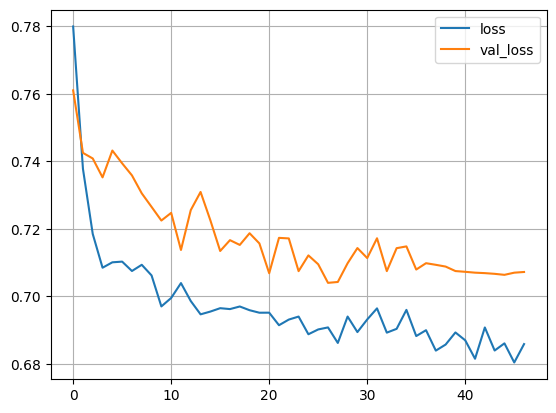

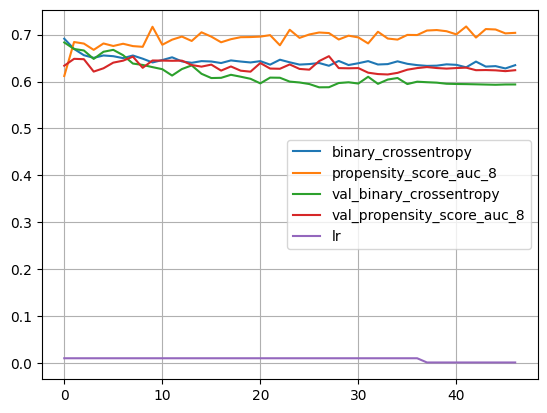

In [69]:
pd.DataFrame(history.history)[["loss", "val_loss"]].plot()
plt.grid()
plt.show()
pd.DataFrame(history.history).drop(["loss", "val_loss"], axis=1).plot()
plt.grid()


32/32 [==============================] - 0s 1ms/step


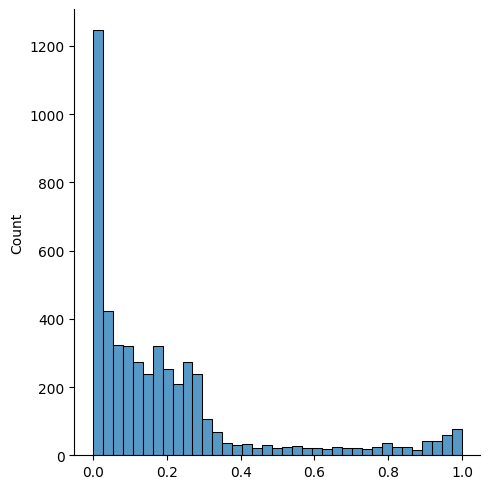

In [70]:
y_pred = model.predict(input_data)
outcome_pred, const_scale, propensity_score, weights = pypsps.utils.split_y_pred(y_pred)
sns.displot(pd.Series(propensity_score.ravel()))

32/32 [==============================] - 0s 2ms/step


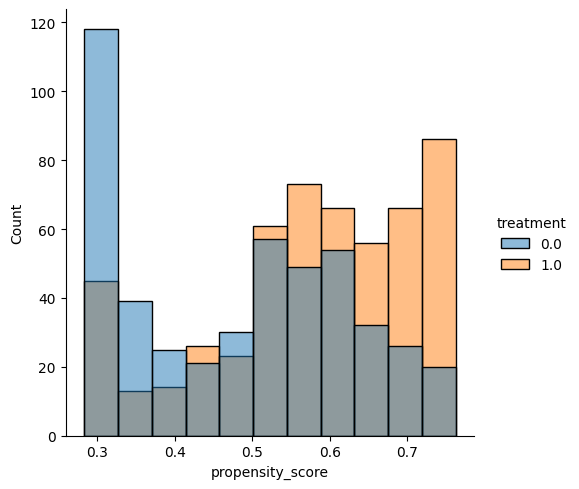

0.6982667194511079 0.529


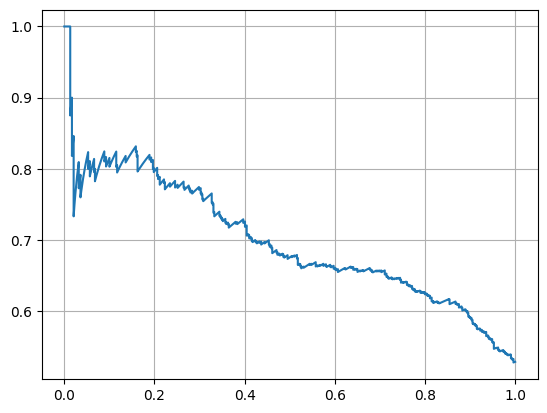

<Axes: >

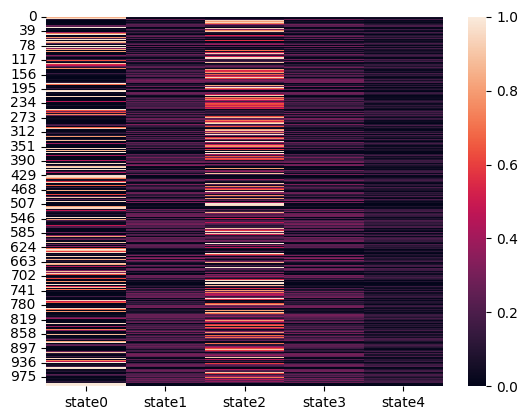

In [71]:
y_pred = model.predict(input_data)
outcome_pred, scale_pred, weights, propensity_score = pypsps.utils.split_y_pred(y_pred)
_eval_propensity(output_data[:, 1], propensity_score.ravel())
weights_df = pd.DataFrame(weights, index=X_s.index, columns=["state" + str(i) for i in range(weights.shape[1])])
sns.heatmap(weights_df.round(2))

In [72]:
psps_causal_loss = pypsps.keras.losses.CausalLoss(outcome_loss=psps_outcome_loss,
                                  treatment_loss=psps_treat_loss,
                                  alpha=1.,
                                  outcome_loss_weight=1.0,
                                  predictive_states_regularizer=pypress.keras.regularizers.DegreesOfFreedom(0.01, df=5 - 1),
                                  reduction="auto")
# Test loss function
print(psps_causal_loss(output_data, y_pred))

model.compile(loss=psps_causal_loss, 
              optimizer=tfk.optimizers.Nadam(learning_rate=0.01), 
              metrics=[pypsps.keras.metrics.propensity_score_crossentropy])

history = model.fit(input_data, output_data, epochs=50, batch_size=64,
                    verbose=2, validation_split=0.2,
                    # callbacks=all_callbacks
                   )

tf.Tensor(2.6017902, shape=(), dtype=float32)
Epoch 1/50
13/13 - 5s - loss: 2.5157 - propensity_score_crossentropy: 0.7491 - val_loss: 2.5616 - val_propensity_score_crossentropy: 0.7379 - 5s/epoch - 367ms/step
Epoch 2/50
13/13 - 0s - loss: 2.5020 - propensity_score_crossentropy: 0.7505 - val_loss: 2.5365 - val_propensity_score_crossentropy: 0.7361 - 68ms/epoch - 5ms/step
Epoch 3/50
13/13 - 0s - loss: 2.5016 - propensity_score_crossentropy: 0.7483 - val_loss: 2.5347 - val_propensity_score_crossentropy: 0.7372 - 65ms/epoch - 5ms/step
Epoch 4/50
13/13 - 0s - loss: 2.4995 - propensity_score_crossentropy: 0.7486 - val_loss: 2.5107 - val_propensity_score_crossentropy: 0.7428 - 66ms/epoch - 5ms/step
Epoch 5/50
13/13 - 0s - loss: 2.4927 - propensity_score_crossentropy: 0.7531 - val_loss: 2.5204 - val_propensity_score_crossentropy: 0.7256 - 68ms/epoch - 5ms/step
Epoch 6/50
13/13 - 0s - loss: 2.4894 - propensity_score_crossentropy: 0.7460 - val_loss: 2.5245 - val_propensity_score_crossentropy: 0

32/32 [==============================] - 0s 1ms/step


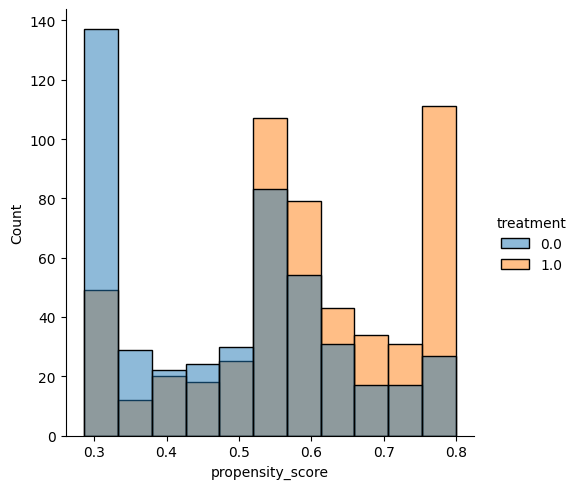

0.6999525193755851 0.529


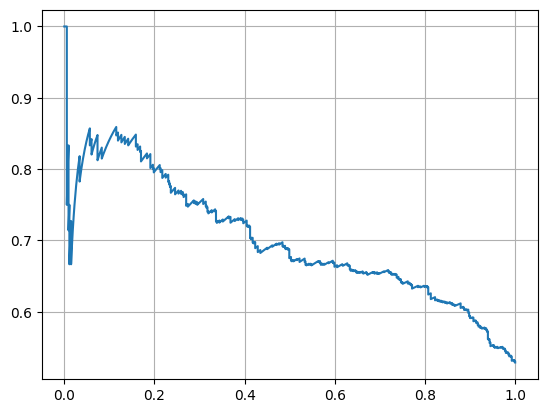

<Axes: >

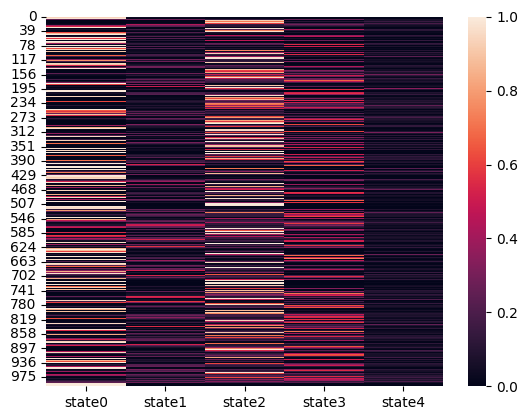

In [73]:
y_pred = model.predict(input_data)
outcome_pred, const_scale, weights, propensity_score = pypsps.utils.split_y_pred(y_pred)
_eval_propensity(output_data[:, 1], propensity_score.ravel())
weights_df = pd.DataFrame(weights, index=X_s.index, columns=["state" + str(i) for i in range(weights.shape[1])])
sns.heatmap(weights_df.round(2))

In [74]:
scale_pred

array([[1.4037724, 1.222523 , 1.3676922, 1.2379489, 1.2034792],
       [1.4037724, 1.222523 , 1.3676922, 1.2379489, 1.2034792],
       [1.4037724, 1.222523 , 1.3676922, 1.2379489, 1.2034792],
       ...,
       [1.4037724, 1.222523 , 1.3676922, 1.2379489, 1.2034792],
       [1.4037724, 1.222523 , 1.3676922, 1.2379489, 1.2034792],
       [1.4037724, 1.222523 , 1.3676922, 1.2379489, 1.2034792]],
      dtype=float32)

In [75]:
tfk.losses.BinaryCrossentropy(reduction="sum")(y_true=treatment.values, y_pred=propensity_score)

<tf.Tensor: shape=(), dtype=float32, numpy=632.34937>

In [76]:
psps_treat_loss.reduction = "sum"
psps_treat_loss(output_data, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=748.90753>

In [77]:
pypsps.keras.metrics.propensity_score_crossentropy(output_data, y_pred).numpy().sum()

748.9075

In [78]:
y_df = pd.DataFrame(outcome_pred, columns=["y_pred" + str(i) for i in range(outcome_pred.shape[1])])
y_df["outcome"] = y.values

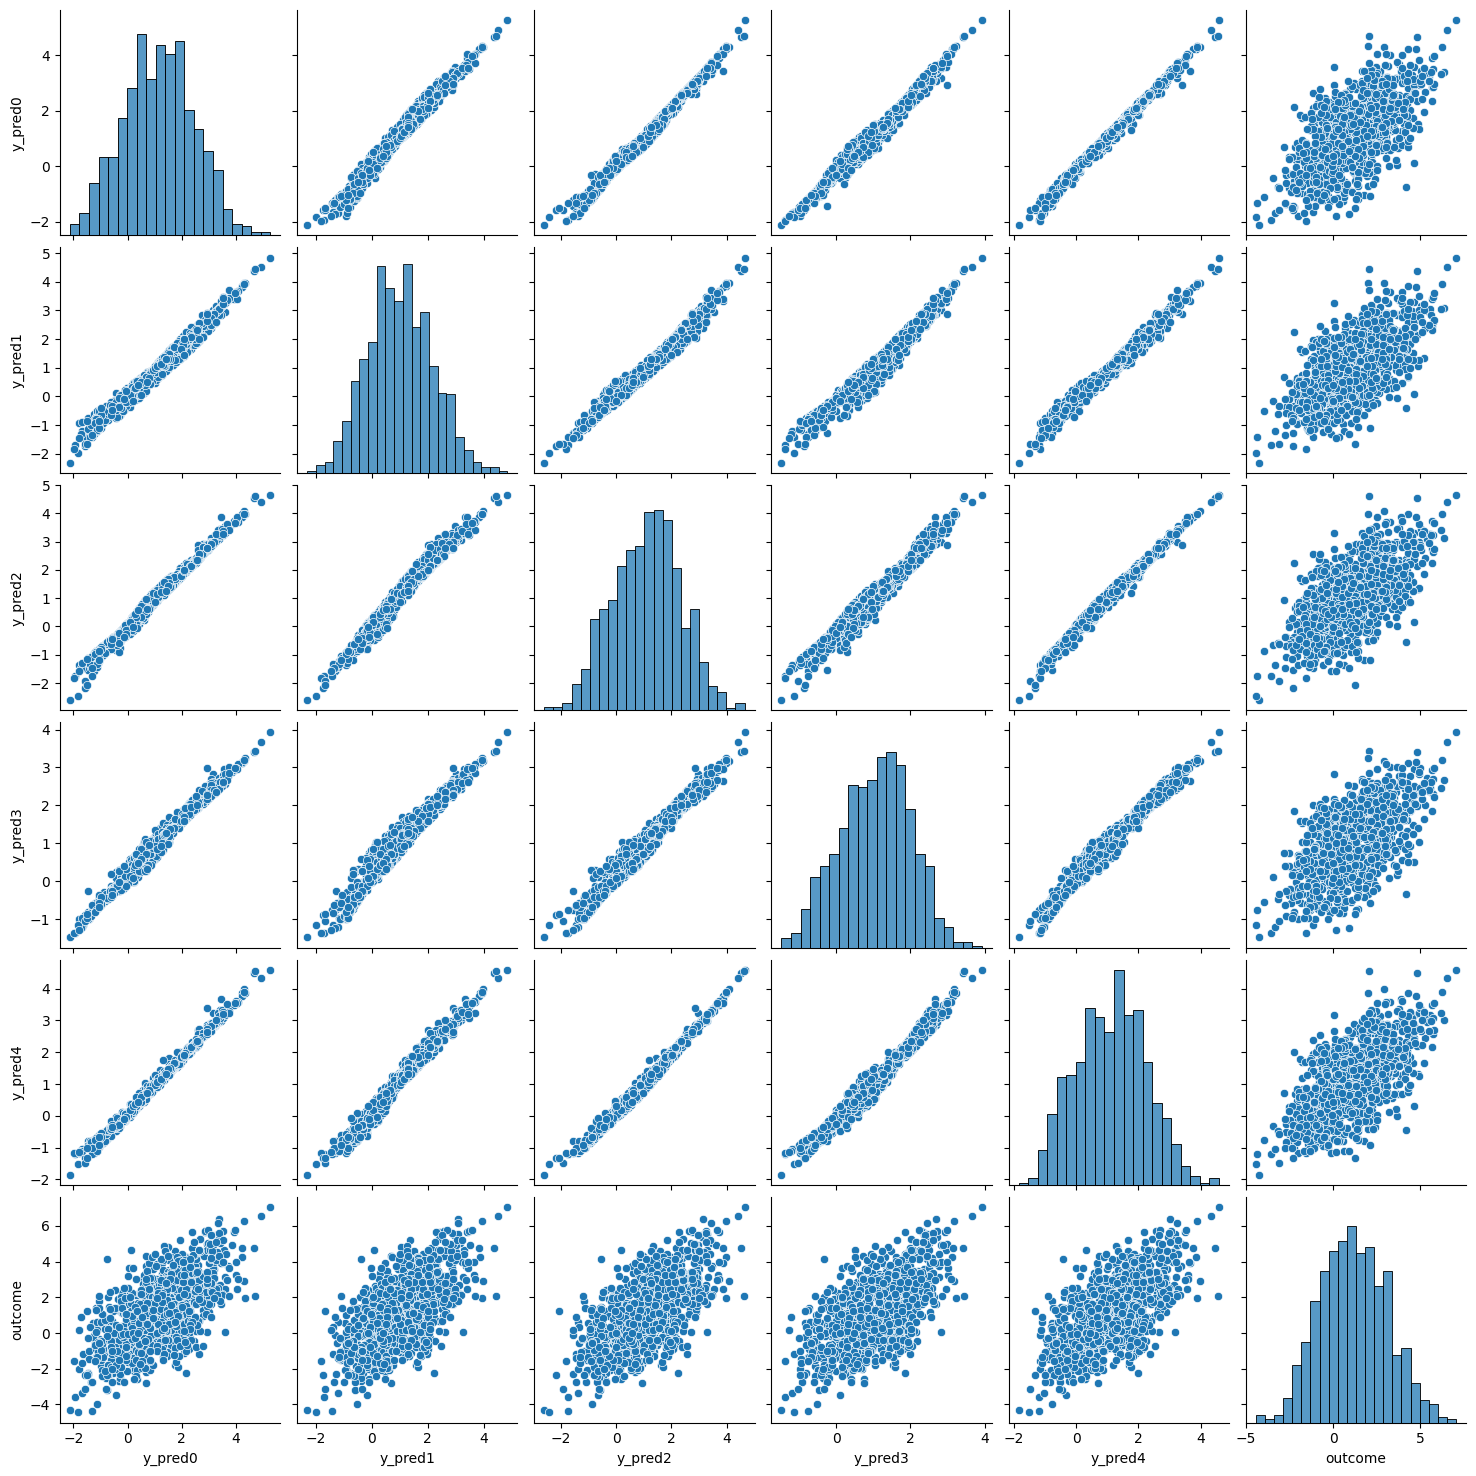

In [79]:
sns.pairplot(y_df)

<Axes: >

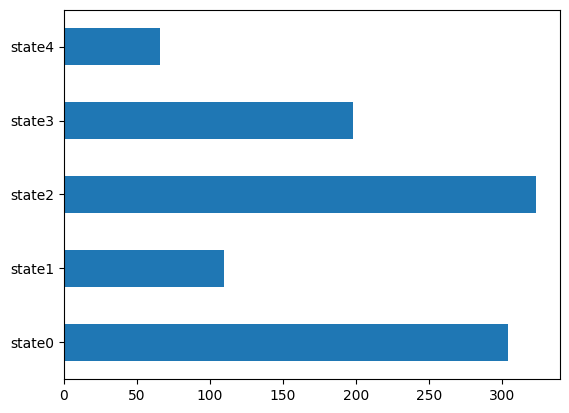

In [80]:
weights_df.sum().plot.barh()

32/32 [==============================] - 0s 1ms/step


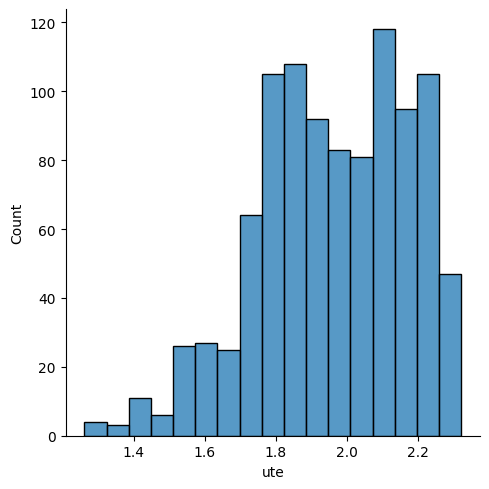

In [81]:
sns.displot(pypsps.inference.predict_ute(model, X_s))

In [82]:
pypsps.inference.predict_ate(model, X_s)

32/32 [==============================] - 0s 1ms/step


1.9594934